In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Load the dataset
def load_data(file_path):
    """Load the stroke prediction dataset from CSV file."""
    return pd.read_csv("healthcare-dataset-stroke-data.csv")

In [3]:
# Exploratory Data Analysis
def explore_data(df):
    """Perform basic exploratory data analysis."""
    print("Dataset shape:", df.shape)
    print("\nData types:")
    print(df.dtypes)
    print("\nMissing values:")
    print(df.isnull().sum())
    print("\nUnique values per column:")
    for col in df.columns:
        print(f"{col}: {df[col].nunique()} unique values")
    
    # Class distribution
    print("\nClass distribution:")
    print(df['stroke'].value_counts())
    print(f"Percentage of stroke cases: {df['stroke'].mean() * 100:.2f}%")
    
    # Basic statistics for numerical columns
    print("\nNumerical features summary:")
    print(df.describe())
    
    return df

In [4]:
# Data preprocessing
def preprocess_data(df, handle_missing='remove'):
    """
    Preprocess the dataset for modeling.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The input dataset
    handle_missing : str, optional (default='remove')
        Strategy for handling missing values: 'remove' or 'impute'
    
    Returns:
    --------
    X : numpy.ndarray
        Feature matrix
    y : numpy.ndarray
        Target vector
    feature_names : list
        Names of the features after preprocessing
    """
    # Make a copy to avoid modifying the original dataframe
    data = df.copy()
    
    # Drop the ID column as it's not useful for prediction
    if 'id' in data.columns:
        data = data.drop('id', axis=1)
    
    # Handle missing values
    if handle_missing == 'remove':
        # Remove rows with missing values
        data = data.dropna()
    elif handle_missing == 'impute':
        # Impute missing values
        # For BMI, use median imputation
        imputer = SimpleImputer(strategy='median')
        data['bmi'] = imputer.fit_transform(data[['bmi']])
    
    # Convert categorical variables to dummy variables
    categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
    data = pd.get_dummies(data, columns=categorical_cols, drop_first=False)
    
    # Extract features and target
    X = data.drop('stroke', axis=1)
    y = data['stroke']
    
    return X, y, X.columns.tolist()

In [5]:
# Feature importance analysis
def analyze_feature_importance(X, y):
    """Analyze feature importance using Random Forest."""
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)
    
    # Get feature importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Print feature ranking
    print("Feature ranking:")
    for i in range(X.shape[1]):
        print(f"{i+1}. {X.columns[indices[i]]} ({importances[indices[i]]:.4f})")
    
    return importances, indices

In [6]:
# Cross-validation for model evaluation
def cross_validate_models(X, y, cv=5):
    """
    Perform cross-validation for multiple models.
    
    Parameters:
    -----------
    X : pandas.DataFrame
        Feature matrix
    y : pandas.Series
        Target vector
    cv : int, optional (default=5)
        Number of cross-validation folds
    
    Returns:
    --------
    cv_results : dict
        Dictionary containing cross-validation results for each model
    """
    # Define models
    models = {
        'RandomForest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
        'SVM': SVC(probability=True, class_weight='balanced', random_state=42),
        'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
    }
    
    # Initialize results dictionary
    cv_results = {}
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Define cross-validation strategy
    cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    for name, model in models.items():
        print(f"\nCross-validating {name}...")
        
        # Track metrics across folds
        fold_accuracies = []
        fold_precisions = []
        fold_recalls = []
        fold_f1_scores = []
        fold_roc_aucs = []
        
        # Perform cross-validation
        for train_index, test_index in cv_strategy.split(X_scaled, y):
            X_train, X_test = X_scaled[train_index], X_scaled[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            # Train model
            model.fit(X_train, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            
            # Calculate metrics
            report = classification_report(y_test, y_pred, output_dict=True)
            
            # Calculate ROC AUC
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            
            # Store metrics
            fold_accuracies.append(report['accuracy'])
            if '1' in report:  # Check if class '1' exists in the report
                fold_precisions.append(report['1']['precision'])
                fold_recalls.append(report['1']['recall'])
                fold_f1_scores.append(report['1']['f1-score'])
            else:
                # Handle case where class '1' might not be in some folds
                fold_precisions.append(0)
                fold_recalls.append(0)
                fold_f1_scores.append(0)
            
            fold_roc_aucs.append(roc_auc)
        
        # Calculate average metrics
        cv_results[name] = {
            'accuracy': np.mean(fold_accuracies),
            'accuracy_std': np.std(fold_accuracies),
            'precision': np.mean(fold_precisions),
            'precision_std': np.std(fold_precisions),
            'recall': np.mean(fold_recalls),
            'recall_std': np.std(fold_recalls),
            'f1_score': np.mean(fold_f1_scores),
            'f1_score_std': np.std(fold_f1_scores),
            'roc_auc': np.mean(fold_roc_aucs),
            'roc_auc_std': np.std(fold_roc_aucs)
        }
        
        # Print results
        print(f"CV Accuracy: {cv_results[name]['accuracy']:.4f} ± {cv_results[name]['accuracy_std']:.4f}")
        print(f"CV Precision: {cv_results[name]['precision']:.4f} ± {cv_results[name]['precision_std']:.4f}")
        print(f"CV Recall: {cv_results[name]['recall']:.4f} ± {cv_results[name]['recall_std']:.4f}")
        print(f"CV F1 Score: {cv_results[name]['f1_score']:.4f} ± {cv_results[name]['f1_score_std']:.4f}")
        print(f"CV ROC AUC: {cv_results[name]['roc_auc']:.4f} ± {cv_results[name]['roc_auc_std']:.4f}")
    
    return cv_results

In [7]:
# Hyperparameter tuning with Grid Search
def optimize_hyperparameters(X, y):
    """
    Perform grid search to optimize hyperparameters.
    
    Parameters:
    -----------
    X : pandas.DataFrame
        Feature matrix
    y : pandas.Series
        Target vector
    
    Returns:
    --------
    best_models : dict
        Dictionary of optimized models
    best_params : dict
        Dictionary of best parameters for each model
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define parameter grids
    param_grids = {
        'RandomForest': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'class_weight': ['balanced', 'balanced_subsample']
        },
        'SVM': {
            'C': [0.1, 1.0, 10.0],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto'],
            'class_weight': ['balanced']
        },
        'LogisticRegression': {
            'C': [0.1, 1.0, 10.0],
            'penalty': ['l2'],
            'solver': ['liblinear', 'lbfgs'],
            'class_weight': ['balanced']
        }
    }
    
    # Initialize dictionaries for best models and parameters
    best_models = {}
    best_params = {}
    best_scores = {}
    
    # Perform grid search for each model
    for model_name, param_grid in param_grids.items():
        print(f"\nOptimizing hyperparameters for {model_name}...")
        
        # Initialize model
        if model_name == 'RandomForest':
            model = RandomForestClassifier(random_state=42)
        elif model_name == 'SVM':
            model = SVC(probability=True, random_state=42)
        elif model_name == 'LogisticRegression':
            model = LogisticRegression(max_iter=1000, random_state=42)
        
        # Define cross-validation strategy
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        # Perform grid search
        grid_search = GridSearchCV(
            model, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=1
        )
        grid_search.fit(X_train_scaled, y_train)
        
        # Get best model and parameters
        best_models[model_name] = grid_search.best_estimator_
        best_params[model_name] = grid_search.best_params_
        best_scores[model_name] = grid_search.best_score_
        
        # Evaluate on test set
        y_pred = best_models[model_name].predict(X_test_scaled)
        test_score = f1_score(y_test, y_pred)
        
        # Print results
        print(f"Best parameters: {best_params[model_name]}")
        print(f"Best CV F1 score: {best_scores[model_name]:.4f}")
        print(f"Test F1 score: {test_score:.4f}")
        print(f"Classification Report:")
        print(classification_report(y_test, y_pred))
    
    return best_models, best_params, best_scores

In [8]:
# Build and evaluate models
def build_and_evaluate_models(X, y, use_smote=False, tuned_models=None):
    """
    Build and evaluate multiple machine learning models.
    
    Parameters:
    -----------
    X : pandas.DataFrame
        Feature matrix
    y : pandas.Series
        Target vector
    use_smote : bool, optional (default=False)
        Whether to apply SMOTE for handling class imbalance
    tuned_models : dict, optional (default=None)
        Pre-tuned models to use instead of default models
    
    Returns:
    --------
    models : dict
        Dictionary of trained models
    results : dict
        Dictionary of model performance metrics
    """
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Apply SMOTE if requested
    if use_smote:
        smote = SMOTE(random_state=42)
        X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)
        print("After SMOTE:")
        print(f"Training set shape: {X_train_scaled.shape}")
        print(f"Class distribution: {np.bincount(y_train)}")
    
    # Initialize models
    if tuned_models is None:
        models = {
            'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
            'SVM': SVC(probability=True, class_weight='balanced', random_state=42),
            'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
        }
    else:
        models = tuned_models
    
    # Train and evaluate models
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train_scaled, y_train)
        
        # Predict on test set
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        # Calculate metrics
        report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)
        
        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Calculate Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        
        # Store results
        results[name] = {
            'classification_report': report,
            'confusion_matrix': cm,
            'roc_curve': {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc},
            'pr_curve': {'precision': precision, 'recall': recall, 'auc': pr_auc}
        }
        
        # Print basic metrics
        print(f"Accuracy: {report['accuracy']:.4f}")
        print(f"Precision (Stroke): {report['1']['precision']:.4f}")
        print(f"Recall (Stroke): {report['1']['recall']:.4f}")
        print(f"F1 Score (Stroke): {report['1']['f1-score']:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")
        print(f"PR AUC: {pr_auc:.4f}")
        print("Confusion Matrix:")
        print(cm)
    
    return models, results

In [9]:
# Analyze Logistic Regression coefficients
def analyze_logistic_regression(model, feature_names):
    """Analyze Logistic Regression coefficients and odds ratios."""
    # Get coefficients
    coef = model.coef_[0]
    
    # Calculate odds ratios
    odds_ratios = np.exp(coef)
    
    # Create a dataframe for better visualization
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coef,
        'Odds Ratio': odds_ratios
    })
    
    # Sort by absolute coefficient value
    coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)
    
    print("Logistic Regression Coefficients and Odds Ratios:")
    print(coef_df)
    
    return coef_df

In [10]:
# Find optimal threshold for imbalanced classification
def find_optimal_threshold(y_true, y_scores):
    """Find the optimal threshold that maximizes F1 score."""
    # Calculate precision and recall for various thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    
    # Calculate F1 score for each threshold
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    
    # Find threshold that maximizes F1 score
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
    
    print(f"Optimal threshold: {optimal_threshold:.4f}")
    print(f"Corresponding precision: {precisions[optimal_idx]:.4f}")
    print(f"Corresponding recall: {recalls[optimal_idx]:.4f}")
    print(f"Corresponding F1 score: {f1_scores[optimal_idx]:.4f}")
    
    return optimal_threshold

In [11]:
# Plot ROC curves for all models
def plot_roc_curves(results):
    """Plot ROC curves for all models."""
    plt.figure(figsize=(10, 8))
    
    for name, result in results.items():
        fpr = result['roc_curve']['fpr']
        tpr = result['roc_curve']['tpr']
        auc = result['roc_curve']['auc']
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.grid(True)
    
    return plt.gcf()

In [12]:
# Plot Precision-Recall curves for all models
def plot_pr_curves(results):
    """Plot Precision-Recall curves for all models."""
    plt.figure(figsize=(10, 8))
    
    for name, result in results.items():
        precision = result['pr_curve']['precision']
        recall = result['pr_curve']['recall']
        auc = result['pr_curve']['auc']
        plt.plot(recall, precision, label=f'{name} (AUC = {auc:.4f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc="lower left")
    plt.grid(True)
    
    return plt.gcf()

In [13]:
# Plot feature importance
def plot_feature_importance(importances, feature_names, top_n=10):
    """Plot feature importance."""
    # Sort feature importances
    indices = np.argsort(importances)[::-1]
    
    # Take top N features
    top_indices = indices[:top_n]
    top_importances = importances[top_indices]
    top_names = [feature_names[i] for i in top_indices]
    
    # Plot
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_names)), top_importances, align='center')
    plt.yticks(range(len(top_names)), top_names)
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Feature Importances')
    plt.tight_layout()
    
    return plt.gcf()

In [14]:
# Plot distribution of numerical features by stroke
def plot_numerical_distributions(df, numerical_cols):
    """Plot distribution of numerical features by stroke status."""
    n_cols = len(numerical_cols)
    fig, axes = plt.subplots(n_cols, 1, figsize=(12, 5 * n_cols))
    
    for i, col in enumerate(numerical_cols):
        ax = axes[i] if n_cols > 1 else axes
        sns.histplot(data=df, x=col, hue='stroke', kde=True, ax=ax)
        ax.set_title(f'Distribution of {col} by Stroke Status')
    
    plt.tight_layout()
    return fig

Dataset shape: (5110, 12)

Data types:
id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

Missing values:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Unique values per column:
id: 5110 unique values
gender: 3 unique values
age: 104 unique values
hypertension: 2 unique values
heart_disease: 2 unique values
ever_married: 2 unique values
work_type: 5 unique values
Residence_type: 2 unique values
avg_glucose_level: 397

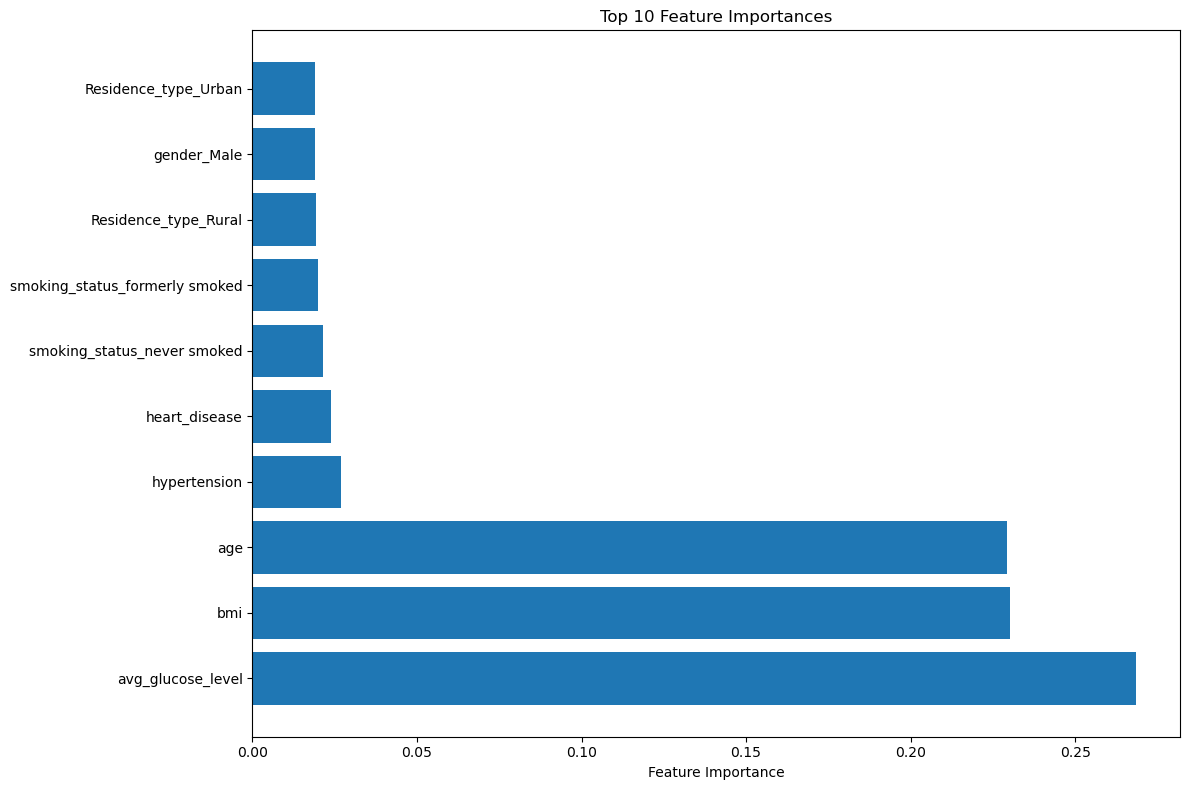

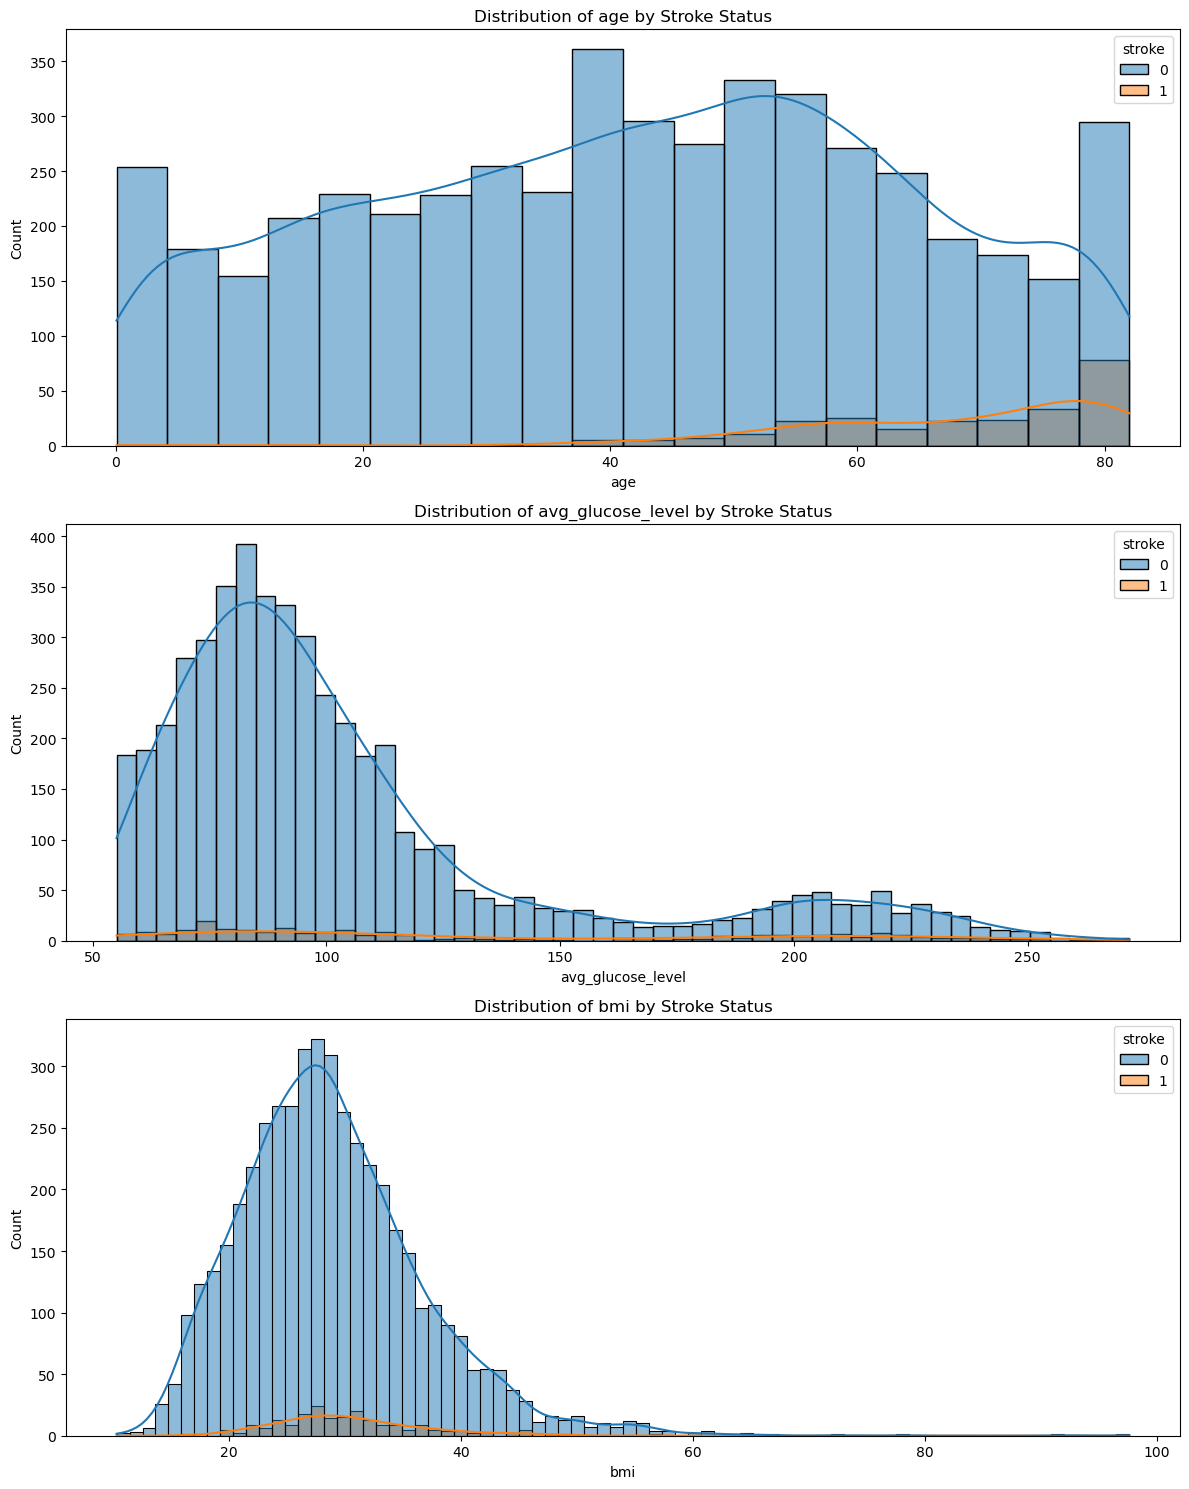

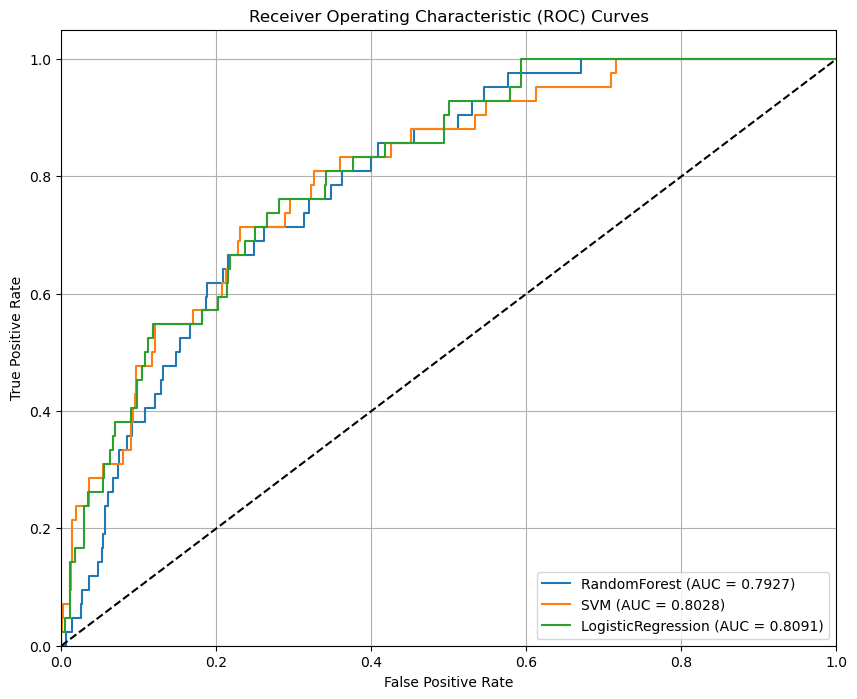

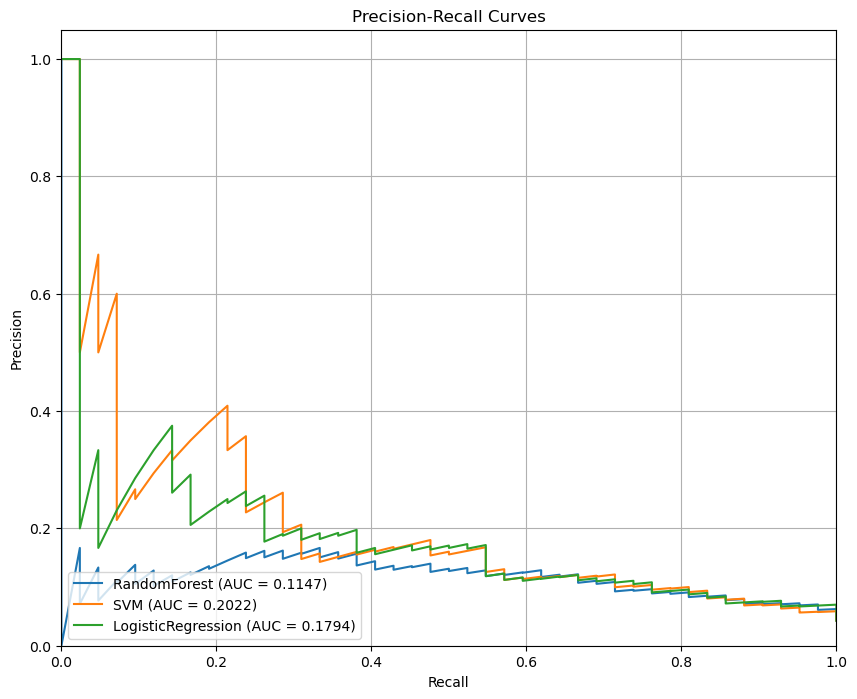

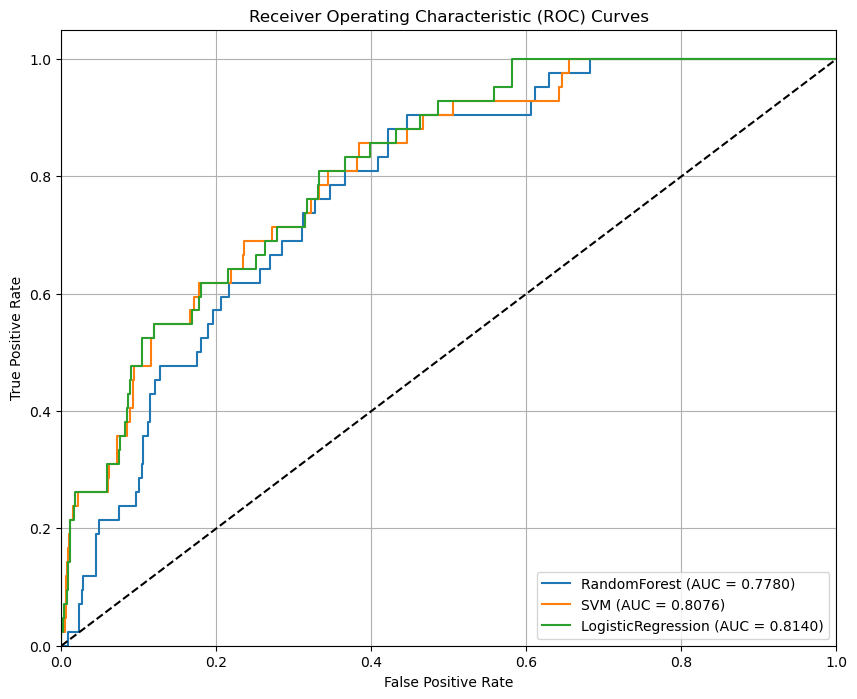

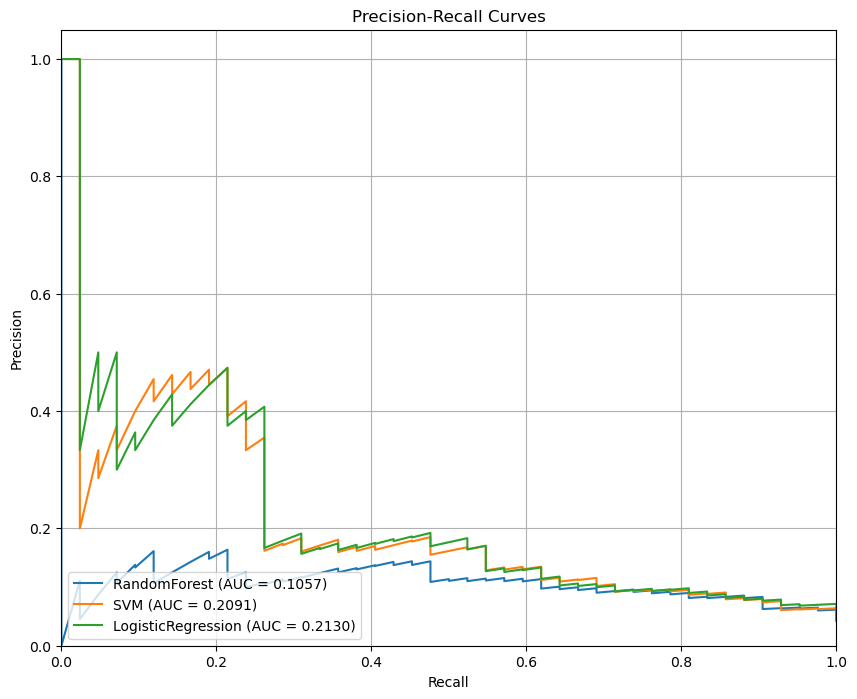

In [15]:
# Main function to run the entire analysis
def main():
    # Load data
    df = load_data('healthcaredatasetstrokedata.csv')
    
    # Explore data
    explore_data(df)
    
    # Preprocess data
    X, y, feature_names = preprocess_data(df, handle_missing='remove')
    
    # Cross-validate models
    print("\n*** Cross-validating models ***")
    cv_results = cross_validate_models(X, y, cv=5)
    
    # Optimize hyperparameters
    print("\n*** Optimizing hyperparameters ***")
    best_models, best_params, best_scores = optimize_hyperparameters(X, y)
    
    # Analyze feature importance using Random Forest
    importances, indices = analyze_feature_importance(X, y)
    
    # Plot feature importance
    fig_importance = plot_feature_importance(importances, feature_names)
    fig_importance.savefig('feature_importance.png')
    
    # Plot distribution of numerical features
    numerical_cols = ['age', 'avg_glucose_level', 'bmi']
    fig_dist = plot_numerical_distributions(df, numerical_cols)
    fig_dist.savefig('numerical_distributions.png')
    
    # Build and evaluate models with optimized hyperparameters
    print("\n*** Training models with optimized hyperparameters ***")
    models, results = build_and_evaluate_models(X, y, use_smote=False, tuned_models=best_models)
    
    # Plot ROC curves
    fig_roc = plot_roc_curves(results)
    fig_roc.savefig('roc_curves.png')
    
    # Plot Precision-Recall curves
    fig_pr = plot_pr_curves(results)
    fig_pr.savefig('pr_curves.png')
    
    # Analyze Logistic Regression coefficients
    lr_model = models['LogisticRegression']
    coef_df = analyze_logistic_regression(lr_model, feature_names)
    
    # Find optimal threshold for Logistic Regression
    print("\n*** Finding optimal threshold for Logistic Regression ***")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_scores = lr_model.predict_proba(X_test_scaled)[:, 1]
    optimal_threshold = find_optimal_threshold(y_test, y_scores)
    
    # Try with SMOTE for comparison
    print("\n*** Training models with SMOTE ***")
    models_smote, results_smote = build_and_evaluate_models(X, y, use_smote=True, tuned_models=best_models)
    
    # Plot ROC curves with SMOTE
    fig_roc_smote = plot_roc_curves(results_smote)
    fig_roc_smote.savefig('roc_curves_smote.png')
    
    # Plot Precision-Recall curves with SMOTE
    fig_pr_smote = plot_pr_curves(results_smote)
    fig_pr_smote.savefig('pr_curves_smote.png')
    
    print("\nAnalysis complete!")

if __name__ == "__main__":
    main()